In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

##1. 데이터 가져오기 

In [2]:
df = pd.read_csv("/content/drive/MyDrive/인공지능 보안/Data_Set /MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv")

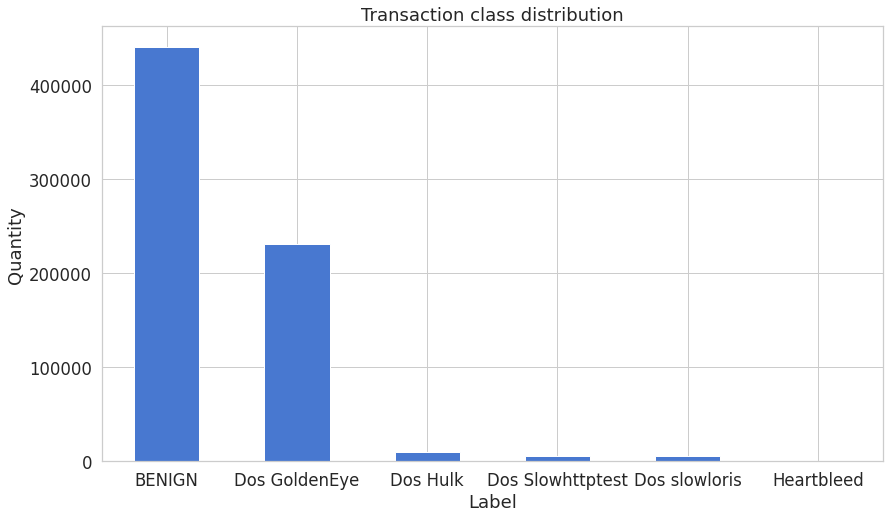

In [ ]:
# 시각화 라이브러리 설정
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["BENIGN","Dos GoldenEye","Dos Hulk","Dos Slowhttptest","Dos slowloris","Heartbleed"]

count_classes = pd.value_counts(df[' Label'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(6), LABELS)
plt.xlabel("Label")
plt.ylabel("Quantity");

##2. 데이터 전처리

* 정상인지 정상이 아닌지만 판별하면 되니, One-hot-encoding 으로 정상과 비정상으로 구분해준다. 

In [3]:
df2_dummie = pd.get_dummies(df)
df = df2_dummie

* Correlation 기반 상관도가 높은 데이터들로 추리고 Label_BENIGN 만 챙긴다. 

In [4]:
### 20개로 Feature 줄임. < Label BENIGN 추가 > 
#df_benign= df[df[' Label']== 'BENIGN']
df_benign_corr_ont_hot_feature = df.loc[:,[' Flow Duration','Bwd Packet Length Max',' Bwd Packet Length Min',' Bwd Packet Length Mean',
                           ' Bwd Packet Length Std',' Flow IAT Mean',' Flow IAT Std',' Flow IAT Max',' Min Packet Length',
                           ' Max Packet Length',' Packet Length Mean',' Packet Length Std',' Packet Length Variance','FIN Flag Count',
                           ' Average Packet Size',' Avg Bwd Segment Size','Idle Mean',' Idle Max',' Idle Min',' Label_BENIGN']]

display(df_benign_corr_ont_hot_feature )

,Flow Duration,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,Average Packet Size,Avg Bwd Segment Size,Idle Mean,Idle Max,Idle Min,Label_BENIGN
0,38308,6,6,6.000000,0.000000,38308.000000,0.000000,38308,6,6,6.000000,0.000000,0.000000,0,9.000000,6.000000,0.0,0,0,1
1,479,163,0,65.200000,89.278777,31.933333,25.510409,73,0,163,29.294118,56.529599,3195.595588,0,31.125000,65.200000,0.0,0,0,1
2,1095,1575,0,525.000000,813.326503,73.000000,204.960972,810,0,1575,370.588235,671.751541,451250.132400,0,393.750000,525.000000,0.0,0,0,1
3,15206,3069,0,555.000000,977.480342,543.071429,2519.931377,13391,0,3069,337.066667,704.654082,496537.374700,0,348.689655,555.000000,0.0,0,0,1
4,1092,1576,0,525.333333,813.842901,78.000000,207.000929,794,0,1576,393.875000,704.585067,496440.116700,0,420.133333,525.333333,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692698,32215,76,76,76.000000,0.000000,6443.000000,13617.579480,30780,28,76,41.714286,23.421602,548.571429,0,48.666667,76.000000,0.0,0,0,1
692699,324,181,181,181.000000,0.000000,108.000000,183.597386,320,42,181,97.600000,76.133435,5796.300000,0,122.000000,181.000000,0.0,0,0,1
692700,82,6,6,6.000000,0.000000,41.000000,52.325902,78,0,31,17.000000,16.350331,267.333333,0,22.666667,6.000000,0.0,0,0,1
692701,1048635,128,128,128.000000,0.000000,149805.000000,375521.040500,1000947,32,128,53.333333,42.332021,1792.000000,0,60.000000,128.000000,0.0,0,0,1


* Min-Max Scalor 데이터 전처리

,Flow Duration,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,Average Packet Size,Avg Bwd Segment Size,Idle Mean,Idle Max,Idle Min,Label_BENIGN
0,0.000319,0.000307,0.00411,0.001633,0.000000,3.219244e-04,0.000000e+00,3.192417e-04,0.005021,0.000242,0.003152,0.000000,0.000000,0.0,0.004352,0.001633,0.000000,0.0000,0.000000,1.0
1,0.000004,0.008346,0.00000,0.017741,0.037775,2.767507e-07,3.114824e-07,6.166667e-07,0.000000,0.006567,0.015391,0.013086,0.000171,0.0,0.015051,0.017741,0.000000,0.0000,0.000000,1.0
2,0.000009,0.080645,0.00000,0.142855,0.344132,6.218487e-07,2.502576e-06,6.758333e-06,0.000000,0.063457,0.194711,0.155506,0.024131,0.0,0.190401,0.142855,0.000000,0.0000,0.000000,1.0
3,0.000127,0.157143,0.00000,0.151018,0.413588,4.572029e-06,3.076839e-05,1.116000e-04,0.000000,0.123650,0.177098,0.163123,0.026553,0.0,0.168612,0.151018,0.000000,0.0000,0.000000,1.0
4,0.000009,0.080696,0.00000,0.142946,0.344351,6.638655e-07,2.527484e-06,6.625000e-06,0.000000,0.063497,0.206946,0.163107,0.026548,0.0,0.203159,0.142946,0.000000,0.0000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.526327,0.000000,0.00000,0.000000,0.000000,8.823530e-02,1.452991e-01,2.675000e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.155833,0.2675,0.066866,0.0
69996,0.526284,0.000000,0.00000,0.000000,0.000000,8.823530e-02,1.452991e-01,2.675000e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.155833,0.2675,0.066801,0.0
69997,0.526241,0.000000,0.00000,0.000000,0.000000,8.823530e-02,1.452991e-01,2.675000e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.155833,0.2675,0.066801,0.0
69998,0.526156,0.000000,0.00000,0.000000,0.000000,8.823530e-02,1.452991e-01,2.675000e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.155833,0.2675,0.066800,0.0


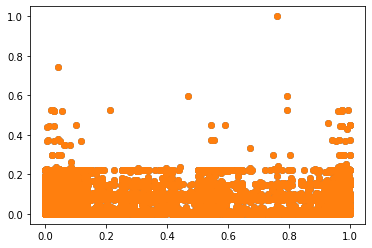

In [5]:
# 평균 0, 분산 1을 갖도록 스케일 조정
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


x=df_benign_corr_ont_hot_feature # Data Set 이름 설정 

x = x[:70000] 
scaler = MinMaxScaler()
scaler.fit(x)
scaled = scaler.transform(x)
df_benign_corr_scaled = pd.DataFrame(scaled,columns=x.columns,index=list(x.index.values))
#output = pd.DataFrame(df_, columns=df.columns, index=list(df.index.values))

display(df_benign_corr_scaled)


RANDOM_SEED = 42

X_train, X_test = train_test_split(df_benign_corr_scaled, test_size=0.3, random_state=RANDOM_SEED)
y_test = X_test[' Label_BENIGN']
X_train = X_train.values.astype('float64') # np.float32 로 바꿔서 해보자. 
X_test = X_test.values.astype('float64') #astype(float) -> astype(np.float32)
plt1=plt.scatter(X_train[:,0],X_train[:,1])
X, _ = make_blobs(n_samples= 200, centers= 5, random_state=4, cluster_std=1.5)
plt2= plt.scatter(X_train[:,0],X_train[:,1])

In [ ]:
display(df_benign_corr_scaled)

## 3. Isolation Forest 적용 / 학습
Sklearn 프레임 워크 사용

* 7만개 데이터 중 63490 이 정상 데이터 

In [6]:
display(df_benign_corr_scaled[' Label_BENIGN'].value_counts())

1.0    63490
0.0     6510
Name:  Label_BENIGN, dtype: int64

In [7]:
from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=50, max_samples=50, contamination=float(0.1), 
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=None, verbose=0,behaviour="new")
# 50개의 노드 수, 최대 50개의 샘플
# 0.04%의 outlier 색출.
clf.fit(df_benign_corr_scaled)
pred = clf.predict(df_benign_corr_scaled)
df_benign_corr_scaled[' Label_BENIGN']=pred
outliers=df_benign_corr_scaled.loc[df_benign_corr_scaled[' Label_BENIGN']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(df_benign_corr_scaled[' Label_BENIGN'].value_counts())

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


 1    63000
-1     7000
Name:  Label_BENIGN, dtype: int64


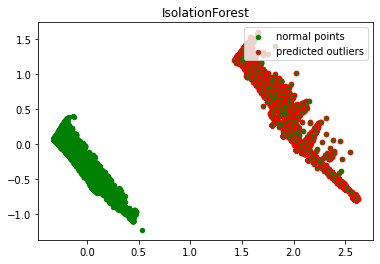

In [8]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(df_benign_corr_scaled)
res=pd.DataFrame(pca.transform(df_benign_corr_scaled))
Z = np.array(res)
plt.title("IsolationForest")
# plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [10]:
from sklearn.tree import export_graphviz

model = clf.estimators_[3]
export_graphviz(model, out_file='tree.dot')

#.dot 를 .png 로 변환

from subprocess import call
call(['dot','-Tpng','tree.dot','-o','iForest-tree.png','-Gdpi=600'])


## inline 출력
from IPython.display import Image
Image(filename='iForest-tree.png')

## 4. 평가

* 이상 데이터로 이상데이터만을 판별 함. 

In [16]:
df_benign_corr_ont_hot_feature_anomaly_data = df_benign_corr_ont_hot_feature[df_benign_corr_ont_hot_feature[' Label_BENIGN']==0]

display(df_benign_corr_ont_hot_feature_anomaly_data)

,Flow Duration,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,Average Packet Size,Avg Bwd Segment Size,Idle Mean,Idle Max,Idle Min,Label_BENIGN
6558,5169956,3525,0,703.666667,1395.868284,3.976889e+05,1368409.299,4951173,0,3525,354.866667,895.115146,8.012311e+05,0,380.214286,703.666667,0.0,0,0,0
26700,229,0,0,0.000000,0.000000,2.290000e+02,0.000,229,6,6,6.000000,0.000000,0.000000e+00,0,9.000000,0.000000,0.0,0,0,0
26701,5001928,0,0,0.000000,0.000000,1.667309e+06,2886995.878,5000925,0,6,2.400000,3.286335,1.080000e+01,0,3.000000,0.000000,0.0,0,0,0
26702,5125872,1047,0,359.142857,420.183860,3.661337e+05,1320784.350,4954614,0,1047,260.812500,322.554847,1.040416e+05,0,278.200000,359.142857,0.0,0,0,0
26703,214,0,0,0.000000,0.000000,2.140000e+02,0.000,214,6,6,6.000000,0.000000,0.000000e+00,0,9.000000,0.000000,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692606,11512204,10184,0,2326.400000,4437.056321,9.593503e+05,2262615.635,6507197,0,10184,854.142857,2713.257986,7.361769e+06,0,919.846154,2326.400000,6507197.0,6507197,6507197,0
692613,11513325,2077,0,705.000000,990.644740,1.279258e+06,2565152.803,6508582,0,2077,363.272727,719.780257,5.180836e+05,0,399.600000,705.000000,6508582.0,6508582,6508582,0
692652,11509201,5792,0,1938.666667,2544.918912,9.591001e+05,2261841.934,6503248,0,5792,853.285714,1857.187221,3.449144e+06,0,918.923077,1938.666667,6503248.0,6503248,6503248,0
692681,11509095,10184,0,2326.400000,4437.056321,9.590912e+05,2262122.237,6504954,0,10184,857.214286,2712.638403,7.358407e+06,0,923.153846,2326.400000,6504954.0,6504954,6504954,0


In [17]:
x=df_benign_corr_ont_hot_feature_anomaly_data
scaler = MinMaxScaler()
scaler.fit(x)
scaled = scaler.transform(x)
Scaled_df_benign_corr_ont_hot_feature_anomaly_data = pd.DataFrame(scaled,columns=x.columns,index=list(x.index.values))
predict_anomaly = clf.predict(Scaled_df_benign_corr_ont_hot_feature_anomaly_data)

df_benign_corr_ont_hot_feature_anomaly_data[' Label_BENIGN']=predict_anomaly
outliers=df_benign_corr_ont_hot_feature_anomaly_data[df_benign_corr_ont_hot_feature_anomaly_data[' Label_BENIGN']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(df_benign_corr_ont_hot_feature_anomaly_data[' Label_BENIGN'].value_counts())


-1    166308
 1     86364
Name:  Label_BENIGN, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


* 정상 데이터로 정상 데이터만을 판별 함. 

In [18]:
df_benign_corr_ont_hot_feature_normal_data = df_benign_corr_ont_hot_feature[df_benign_corr_ont_hot_feature[' Label_BENIGN']==1]

display(df_benign_corr_ont_hot_feature_normal_data)

,Flow Duration,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,Average Packet Size,Avg Bwd Segment Size,Idle Mean,Idle Max,Idle Min,Label_BENIGN
0,38308,6,6,6.000000,0.000000,38308.000000,0.000000,38308,6,6,6.000000,0.000000,0.000000,0,9.000000,6.000000,0.0,0,0,1
1,479,163,0,65.200000,89.278777,31.933333,25.510409,73,0,163,29.294118,56.529599,3195.595588,0,31.125000,65.200000,0.0,0,0,1
2,1095,1575,0,525.000000,813.326503,73.000000,204.960972,810,0,1575,370.588235,671.751541,451250.132400,0,393.750000,525.000000,0.0,0,0,1
3,15206,3069,0,555.000000,977.480342,543.071429,2519.931377,13391,0,3069,337.066667,704.654082,496537.374700,0,348.689655,555.000000,0.0,0,0,1
4,1092,1576,0,525.333333,813.842901,78.000000,207.000929,794,0,1576,393.875000,704.585067,496440.116700,0,420.133333,525.333333,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692698,32215,76,76,76.000000,0.000000,6443.000000,13617.579480,30780,28,76,41.714286,23.421602,548.571429,0,48.666667,76.000000,0.0,0,0,1
692699,324,181,181,181.000000,0.000000,108.000000,183.597386,320,42,181,97.600000,76.133435,5796.300000,0,122.000000,181.000000,0.0,0,0,1
692700,82,6,6,6.000000,0.000000,41.000000,52.325902,78,0,31,17.000000,16.350331,267.333333,0,22.666667,6.000000,0.0,0,0,1
692701,1048635,128,128,128.000000,0.000000,149805.000000,375521.040500,1000947,32,128,53.333333,42.332021,1792.000000,0,60.000000,128.000000,0.0,0,0,1


In [19]:
x=df_benign_corr_ont_hot_feature_normal_data
scaler = MinMaxScaler()
scaler.fit(x)
scaled = scaler.transform(x)
Scaled_df_benign_corr_ont_hot_feature_normal_data = pd.DataFrame(scaled,columns=x.columns,index=list(x.index.values))
predict = clf.predict(Scaled_df_benign_corr_ont_hot_feature_normal_data)

df_benign_corr_ont_hot_feature_normal_data[' Label_BENIGN']=predict
outliers=df_benign_corr_ont_hot_feature_normal_data[df_benign_corr_ont_hot_feature_normal_data[' Label_BENIGN']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(df_benign_corr_ont_hot_feature_normal_data[' Label_BENIGN'].value_counts())


 1    404416
-1     35615
Name:  Label_BENIGN, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Precision 과 Recall 측정

* 정상 데이터 정상 판별 ( TRUE POSITIVE ) = 420581

In [22]:
TP = df_benign_corr_ont_hot_feature_normal_data[df_benign_corr_ont_hot_feature_normal_data[' Label_BENIGN']==1].shape[0]

* 정상 데이터 비정산 판별 ( TRUE NEGATIVE ) = 19450

In [23]:
TN = df_benign_corr_ont_hot_feature_normal_data[df_benign_corr_ont_hot_feature_normal_data[' Label_BENIGN']==-1].shape[0]

* 비정상 데이터 비정상 판별 ( FALSE POSITIVE ) = 164613

In [24]:
FP = df_benign_corr_ont_hot_feature_anomaly_data[df_benign_corr_ont_hot_feature_anomaly_data[' Label_BENIGN']==-1].shape[0]

* 비정상 데이터 정상 판별 ( FALSE NEGATIVE ) 

In [25]:
FN = df_benign_corr_ont_hot_feature_anomaly_data[df_benign_corr_ont_hot_feature_anomaly_data[' Label_BENIGN']==1].shape[0]

### ROC Curve

In [ ]:
### 20개로 Feature 줄임. < Label BENIGN 추가 > 
#df_benign= df[df[' Label']== 'BENIGN']
df_benign_corr_ont_hot_feature = df.loc[:,[' Flow Duration','Bwd Packet Length Max',' Bwd Packet Length Min',' Bwd Packet Length Mean',
                           ' Bwd Packet Length Std',' Flow IAT Mean',' Flow IAT Std',' Flow IAT Max',' Min Packet Length',
                           ' Max Packet Length',' Packet Length Mean',' Packet Length Std',' Packet Length Variance','FIN Flag Count',
                           ' Average Packet Size',' Avg Bwd Segment Size','Idle Mean',' Idle Max',' Idle Min',' Label_BENIGN']]

x = df_benign_corr_ont_hot_feature

scaler = MinMaxScaler()
scaler.fit(x)
scaled = scaler.transform(x)
df_benign_corr_scaled = pd.DataFrame(scaled,columns=x.columns,index=list(x.index.values))

y_test = df_benign_corr_scaled[' Label_BENIGN']
display(y_test)

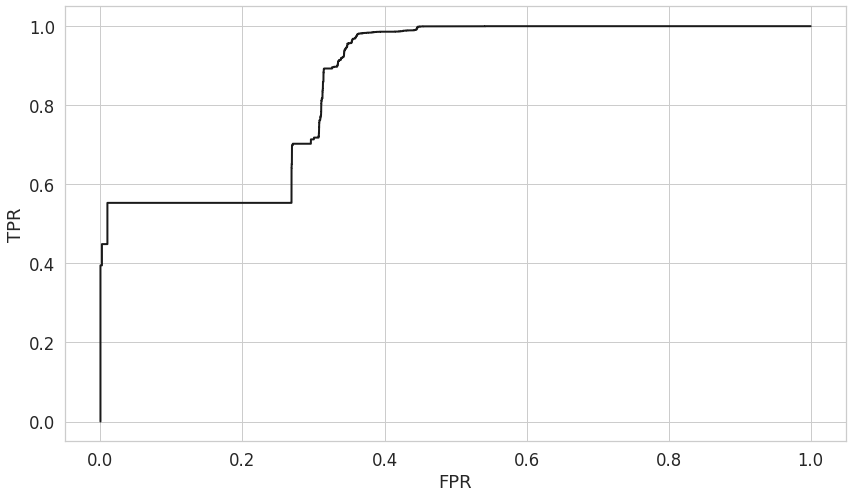

In [ ]:
y_pred = clf.score_samples(df_benign_corr_scaled)

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

### Accuracy , Recall , Precision 

In [26]:
print("Accuracy : ", ( TP+TN )/(TP+TN+FP+FN))
print("Recall : ", TP/(TP+FN))
recall = TP/(TP+FN)
print("Precision :", TP/(TP+FP))
precision = TP/(TP+FP)
print("F1 Score :", 2*(precision*recall)/(precision+recall))

Accuracy :  0.6352376126565065
Recall :  0.8240270589673581
Precision : 0.7086017059033789
F1 Score : 0.7619679247558182
